In [4]:
import numpy as np
import sdf
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy import special
%matplotlib inline

FONTSIZE = 7
COLUMN_WIDTH = 468.0 * 1/72.27
COLUMN_HALFSIZE = 0.5 # Multiplier
COLUMN_THIRDSIZE = 0.32

# This is here to allow for changing of font size
import matplotlib.pyplot as plt

from print_energy import Energy

In [5]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2,3])

    if fig_width is None:
        if columns == 1:
            fig_width = COLUMN_WIDTH
        elif columns == 2:
            fig_width = COLUMN_WIDTH * COLUMN_HALFSIZE  
        else:
            fig_width = COLUMN_WIDTH * COLUMN_THIRDSIZE

    if fig_height is None:
        golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
        
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ['\\usepackage{gensymb}', r"\usepackage{amsmath}"],
              'axes.labelsize': FONTSIZE, # fontsize for x and y labels (was 10)
              'axes.titlesize': FONTSIZE,
              'font.size': FONTSIZE, # was 10
              'legend.fontsize': FONTSIZE, # was 10
              'xtick.labelsize': FONTSIZE,
              'ytick.labelsize': FONTSIZE,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

latexify()

In [330]:
def get_var_slice(sdfFilename, variable):
    sdfFile = sdf.read(sdfFilename)

    sdf_var = getattr(sdfFile, variable)
    var = sdf_var.data
    dims = sdf_var.dims

    # If z-dimensions even, average between midpoints
    average = (dims[2] % 2 == 0)

    if average:
        return 0.5*(var[:,:,int(dims[2]/2)-1] + var[:,:,int(dims[2]/2)]).transpose()
    else:
        return var[:,:,int(dims[2]/2)].transpose()

def mean_difference(var_slice, is_sum_of_differences=True):
#     new_slice = var_slice[:,220:240]
    new_slice = var_slice
    half_size = int(new_slice.shape[0]/2)

    if new_slice.shape[0] % 2 == 0:
        index_shift = 0
    else:
        index_shift = 1
        
    if is_sum_of_differences:
        difference = np.mean((np.abs(new_slice) - np.abs(new_slice[::-1]))[:half_size])
    else:
        difference = np.mean(np.abs(new_slice[:half_size])) - np.mean(np.abs(new_slice[half_size+index_shift:]))
    
    return difference

def get_dx_dy_dz(sdfFilename):
    sdfFile = sdf.read(sdfFilename)
    
    extents = sdfFile.Grid_Grid.extents
    dims = sdfFile.Grid_Grid.dims
    
    dims = [dim + 1 for dim in dims]
    
    return [(extents[i+3] - extents[i])/dims[i] for i in range(3)]

def get_magnetic_field(sdfFilename):
    sdfFile = sdf.read(sdfFilename)
    
    mag_field = np.array([
        getattr(sdfFile, variable).data for variable in 
        ['Magnetic_Field_bx_centred', 'Magnetic_Field_by_centred', 'Magnetic_Field_bz_centred']
    ])

    return mag_field

def curl(bx, by, bz, dx, dy, dz):
    gradbx = np.gradient(bx, dx, dy, dz)
    gradby = np.gradient(by, dx, dy, dz)
    gradbz = np.gradient(bz, dx, dy, dz)
    
    return np.array([(gradbz[1] - gradby[2]), -(gradbz[0] - gradbx[2]), (gradby[0] - gradbx[1])])

def get_current(sdfFilename):
    field = get_magnetic_field(sdfFilename)
    dx, dy, dz = get_dx_dy_dz(sdfFilename)
    current = curl(field[0], field[1], field[2], dx, dy, dz)

def get_mean_current(sdfFilename):
    field = get_magnetic_field(sdfFilename)
    dx, dy, dz = get_dx_dy_dz(sdfFilename)

    gradbx = np.gradient(field[0], dx, dy, dz)
    gradby = np.gradient(field[1], dx, dy, dz)
    gradbz = np.gradient(field[2], dx, dy, dz)

    mean = np.mean(np.sqrt(np.power(gradbz[1] - gradby[2], 2) + np.power(gradbz[0] - gradbx[2], 2) + np.power(gradby[0] - gradbx[1], 2)))
    
    del field, gradbx, gradby, gradbz
    
    return mean

def load_slices(folder, timedumps, variable):
    filenames = [folder + "" + format(timedump, "04d") + ".sdf" for timedump in timedumps]
    slices = [get_var_slice(filename, variable) for filename in filenames]
    
    return slices

def calc_differences(slices, sum_of_differences=False):
    return [mean_difference(var_slice, sum_of_differences) for var_slice in slices]

def load_differences(folder, timedumps, variable):
    slices = load_slices(folder, timedumps, variable)
    return calc_differences(slices)

def remove_spines(axis):
    axis.spines['top'].set_visible(False)
    axis.xaxis.set_ticks_position('bottom')
    axis.spines['right'].set_visible(False)
    axis.yaxis.set_ticks_position('left')
    axis.yaxis.set_label_position('left')

def delta(connectivities, j):
    return ((connectivities[j] - connectivities[j-1]) != 0).astype(int)\
#          + ((connectivities[j] - connectivities[j-1]) < 0).astype(int)

def fix_current_restart(data):
    minimum = data[1:].argmin()
    if data[minimum+1] < 0.001:
        data[minimum+1] = 0.5*(data[minimum] + data[minimum+2])
        
def fix_ohmic_heating_restart(data):
    for i in range(2):
        diff = data[1:] - data[:-1]
        if np.any(np.abs(diff) > 0.01):
            max_point = np.argmax(np.abs(diff))
            print(max_point, data[max_point-1:max_point+1], diff[max_point-1:max_point+1])
            if diff[max_point] > 0:
                data[max_point+1:] += diff[max_point]
            else:
                data[max_point+1:] -= diff[max_point]

def get_maxes(filenames, index, min_time=-1, max_time=-1):
    energies = [Energy(f) for f in filenames]
    return [get_max(en.data, index, min_time, max_time) for en in energies]

def get_max(data, index, min_time=-1, max_time=-1):
    if max_time > 0:
        max_index = find_nearest(data[:,0], max_time)
    else:
        max_index = len(data[:,0])+1
        
    if min_time > 0:
        min_index = find_nearest(data[:,0], min_time)
    else:
        min_index = 0
    
    return np.max(data[min_index:max_index, index])

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Parallel electric field

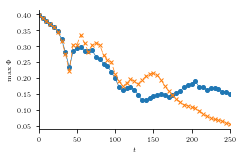

In [22]:
iso_timedumps = [n for n in range(0, 51)]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-isotropic/Data/"
isotropic_pef = [np.load(folder + "pef_" + format(timedump, "04d") + ".sdf.npy") for timedump in iso_timedumps]
swi_timedumps = [n for n in range(0, 51)]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-switching/Data/"
switching_pef = [np.load(folder + "pef_" + format(timedump, "04d") + ".sdf.npy") for timedump in swi_timedumps]

latexify(columns=2)

fig, axis = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.16, right=.97, top=.99)
total_pef_isotropic = [10*np.mean(np.abs(pef)) for pef in isotropic_pef]
total_pef_switching = [10*np.mean(np.abs(pef)) for pef in switching_pef]

eta = 5*np.power(10, -4.5)

max_pef_isotropic = [eta*np.max(np.abs(pef)) for pef in isotropic_pef]
max_pef_switching = [eta*np.max(np.abs(pef)) for pef in switching_pef]

# n_rows = max_dump - min_dump
n_columns = 2
# times = range(0, 10 * n_rows, 10)
iso_times = np.array(iso_timedumps) * 5
swi_times = np.array(swi_timedumps) * 5

axis.plot(iso_times, max_pef_isotropic, 'o-', color="tab:blue", markersize=4, linewidth=0.7, label=r"Max Isotropic")
axis.plot(swi_times, max_pef_switching, 'x--', color="tab:orange", markersize=4, linewidth=0.7, label=r"Max Switching")
plt.ylabel(r"max $\Phi$")

# To plot mean parallel electric field on same axis:
# axis2 = axis.twinx()
# axis2.plot(iso_times, total_pef_isotropic, 'or-', label=r"Mean $10\times|E_{\parallel}|$ - Isotropic")
# axis2.plot(swi_times, total_pef_switching, 'xr--', label=r"Mean $10\times|E_{\parallel}|$ - Switching")
# plt.ylabel(r"Mean $|E_{\parallel}|$")

remove_spines(axis)

plt.xlabel(r"$t$")
plt.xlim(iso_times[0], iso_times[-1])

# axis.legend()
# plt.tight_layout()
plt.savefig('max_parallel_electric_field.pdf', pad_inches=0.0)
plt.show()

In [8]:
print(np.max(isotropic_pef[10]))

4.17068516634


# Plotting Change in Connectivity

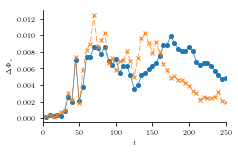

In [33]:
iso_timedumps = [n for n in range(0, 51)]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-isotropic/Data/"
isotropic_connectivity = [np.load(folder + "connectivity_" + format(timedump, "04d") + ".sdf.npy") for timedump in iso_timedumps]
swi_timedumps = [n for n in range(0, 51)]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-switching/Data/"
switching_connectivity = [np.load(folder + "connectivity_" + format(timedump, "04d") + ".sdf.npy") for timedump in swi_timedumps]

latexify(columns=2)

fig, axis = plt.subplots()
fig.subplots_adjust(left=.185, bottom=.19, right=.97, top=.97)

iso_mean_deltas = [np.mean(np.abs(delta(isotropic_connectivity, i))) for i in iso_timedumps[1:]]
swi_mean_deltas = [np.mean(np.abs(delta(switching_connectivity, i))) for i in swi_timedumps[1:]]

n_columns = 2
# times = range(0, 10 * n_rows, 10)
iso_times = np.array(iso_timedumps) * 5
swi_times = np.array(swi_timedumps) * 5

axis.plot(iso_times[1:], iso_mean_deltas, 'o-', color="tab:blue", markersize=4, linewidth=0.7, label=r"Isotropic")
axis.plot(swi_times[1:], swi_mean_deltas, 'x--', color="tab:orange", markersize=4, linewidth=0.7, label=r"Switching")
plt.ylabel(r"$\Delta\Phi_c$")

# axis2 = axis.twinx()
# axis2.plot(times, total_connectivity_isotropic, 'or-', label=r"Mean $10\times|E_{\parallel}|$ - Isotropic")
# axis2.plot(times, total_connectivity_switching, 'xr--', label=r"Mean $10\times|E_{\parallel}|$ - Switching")
# plt.ylabel(r"Mean $|E_{\parallel}|$")

remove_spines(axis)

plt.xlabel(r"$t$")
plt.xlim(iso_times[0], iso_times[-1])

# axis.legend()
# plt.tight_layout()
plt.savefig('mean_difference_in_connectivity.pdf', pad_inches=0.0)
plt.show()

# Plots from en.dat (kinetic energy, current, heating, etc)

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 885384
n_timesteps: 98376
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 989523
n_timesteps: 109947
offset: 0


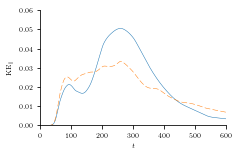

In [5]:
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/long-run-cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-isotropic/Data/"
isotropic_energy = Energy(folder + "en.dat")
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/long-run-cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-switching/Data/"
switching_energy = Energy(folder + "en.dat")

fix_current_restart(isotropic_energy.data[:,8])
fix_current_restart(switching_energy.data[:,8])

latexify(columns=2)

fig, axis = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.17, right=.95, top=.97)

axis.plot(isotropic_energy.data[:,0], isotropic_energy.data[:,6], '-', linewidth=0.5)
axis.plot(switching_energy.data[:,0], switching_energy.data[:,6], '--', linewidth=0.5)
# axis.text(350, 0.05, r'KE$_{\parallel}$')

plt.xlim(0, 600)
plt.ylim(0, 0.06)

plt.xlabel(r"$t$")
plt.ylabel(r'KE$_{\parallel}$')
remove_spines(axis)

plt.savefig('parallel_kinetic_energy_over_time.pdf', pad_inches=0.0)

plt.show()

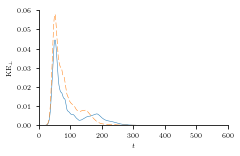

In [10]:
latexify(columns=2)

fig, axis = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.17, right=.96, top=.97)


axis.plot(isotropic_energy.data[:,0], isotropic_energy.data[:,7], '-', linewidth=0.5)
axis.plot(switching_energy.data[:,0], switching_energy.data[:,7], '--', linewidth=0.5)

# axis.text(350, 0.05, r'KE$_{\perp}$')

plt.xlim(0, 600)
plt.ylim(0, 0.06)

plt.xlabel(r"$t$")
plt.ylabel(r'KE$_{\perp}$')
remove_spines(axis)

plt.savefig('perp_kinetic_energy_over_time.pdf', pad_inches=0.0)

plt.show()

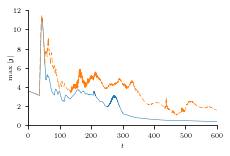

In [11]:
latexify(columns=2)

fig, axis = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.17, right=.96, top=.97)

fix_current_restart(isotropic_energy.data[:,8])
fix_current_restart(switching_energy.data[:,8])

axis.plot(isotropic_energy.data[:,0], isotropic_energy.data[:,8], '-', linewidth=0.5)
axis.plot(switching_energy.data[:,0], switching_energy.data[:,8], '--', linewidth=0.5)

# axis.text(340, 10, r'max $|\boldsymbol{\jmath}|$')

plt.xlim(0, 600)
plt.ylim(0, 12)

plt.xlabel(r"$t$")
plt.ylabel(r'max $|\boldsymbol{\jmath}|$', labelpad=-1)

remove_spines(axis)

plt.savefig('current_density_over_time.pdf', pad_inches=0.0)
plt.show()

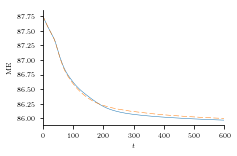

In [14]:
latexify(columns=2)

fig, axis = plt.subplots()
fig.subplots_adjust(left=.18, bottom=.17, right=.96, top=.97)

axis.plot(isotropic_energy.data[:,0], isotropic_energy.data[:,1], '-', linewidth=0.5)
axis.plot(switching_energy.data[:,0], switching_energy.data[:,1], '--', linewidth=0.5)

# axis.text(340, 10, r'max $|\boldsymbol{\jmath}|$')

plt.xlim(0, 600)
# plt.ylim(0, 90)

plt.xlabel(r"$t$")
plt.ylabel(r'ME')

remove_spines(axis)

# plt.savefig('magnetic_energy_density_over_time.pdf', pad_inches=0.0)
plt.show()

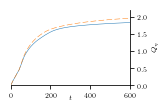

In [20]:
latexify(columns=3)

fig, axis = plt.subplots()
fig.subplots_adjust(left=.01, bottom=.17, right=.81, top=.99)

fix_ohmic_heating_restart(isotropic_energy.data[:,5])
fix_ohmic_heating_restart(switching_energy.data[:,5])

axis.plot(isotropic_energy.data[:,0], isotropic_energy.data[:,5], '-', linewidth=0.5)
axis.plot(switching_energy.data[:,0], switching_energy.data[:,5], '--', linewidth=0.5)
# axis.text(350, 0.6, r'$Q_{\eta}$')

plt.xlim(0, 600)
plt.ylim(0, 2.2)

plt.xlabel(r"$t$", labelpad=-4)
plt.ylabel(r'$Q_{\eta}$')
remove_spines(axis)

axis.spines['right'].set_visible(True)
axis.spines['left'].set_visible(False)
axis.yaxis.set_ticks_position('right')
axis.yaxis.set_label_position('right')

plt.savefig('ohmic_heating_over_time.pdf', pad_inches=0.0)

plt.show()

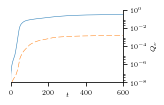

In [23]:
latexify(columns=3)
fig, axis = plt.subplots()
fig.subplots_adjust(left=.015, bottom=.17, right=.77, top=.955)

axis.semilogy(isotropic_energy.data[:,0], isotropic_energy.data[:,4], '-', linewidth=0.5)
axis.semilogy(switching_energy.data[:,0], switching_energy.data[:,4], '--', linewidth=0.5)

# axis.text(350, 1e-6, r'$Q_{\nu}$')

plt.xlim(0, 600)
plt.ylim(1e-8, 1)
# plt.ylim(0, 0.06)

plt.xlabel(r"$t$", labelpad=-4)
plt.ylabel(r'$Q_{\nu}$')
remove_spines(axis)

axis.spines['right'].set_visible(True)
axis.spines['left'].set_visible(False)
axis.yaxis.set_ticks_position('right')
axis.yaxis.set_label_position('right')

plt.savefig('viscous_heating_over_time.pdf', pad_inches=0.0)

plt.show()

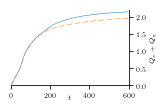

In [29]:
latexify(columns=3)
fig, axis = plt.subplots()
fig.subplots_adjust(left=.01, bottom=.17, right=.80, top=.99)

fix_ohmic_heating_restart(isotropic_energy.data[:,5])
fix_ohmic_heating_restart(switching_energy.data[:,5])

iso_total_heating = isotropic_energy.data[:,4] + isotropic_energy.data[:,5]
swi_total_heating = switching_energy.data[:,4] + switching_energy.data[:,5]

axis.plot(isotropic_energy.data[:,0], iso_total_heating, '-', linewidth=0.5)
axis.plot(switching_energy.data[:,0], swi_total_heating, '--', linewidth=0.5)
# axis.text(320, 0.6, r'$Q_{\nu} + Q_{\eta}$')

plt.xlim(-2, 600)
plt.ylim(0, 2.2)

plt.xlabel(r"$t$", labelpad=-4)
plt.ylabel(r'$Q_{\nu} + Q_{\eta}$')
remove_spines(axis)

axis.spines['right'].set_visible(True)
axis.spines['left'].set_visible(False)
axis.yaxis.set_ticks_position('right')
axis.yaxis.set_label_position('right')

plt.savefig('total_heating_over_time.pdf', pad_inches=0.0)

plt.show()

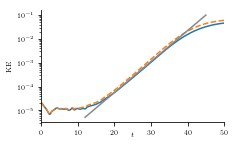

In [32]:
fig, axis = plt.subplots()
fig.subplots_adjust(left=.185, bottom=.19, right=.97, top=.97)

axis.semilogy(isotropic_energy.data[:,0], isotropic_energy.data[:,2], '-')
axis.semilogy(switching_energy.data[:,0], switching_energy.data[:,2], '--')

points = [12, 45]
growthLine = [np.power(10, 3.25/25*(x-15) - 4.9) for x in points]

axis.plot(points, growthLine, color='#888888')

plt.xlim(0, 50)
# plt.ylim(0, 12)

plt.xlabel(r"$t$", labelpad=-4)
plt.ylabel(r'KE')

remove_spines(axis)

plt.savefig('log_kinetic_energy_over_time.pdf', pad_inches=0.0)
plt.show()

# Plotting $\alpha$

/maths/scratch/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in sqrt


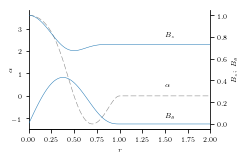

In [94]:
latexify(columns=2)
fig, axis = plt.subplots()
fig.subplots_adjust(left=.1, bottom=.16, right=.88, top=.99)

r = np.linspace(0, 2, 100)

alpha = np.zeros_like(r)
bz = np.zeros_like(r)
bth = np.zeros_like(r)

lamb = 1.8

bz[r<=1] = np.sqrt(1 - lamb*lamb/7 + lamb*lamb/7*np.power(1-r*r, 7) - lamb*lamb*r*r*np.power(1-r*r,6))[r<1]
bz[r>1] = np.sqrt(1 - lamb*lamb/7)
bth[r<=1] = (lamb*r*np.power(1-r*r,3))[r<=1]
alpha[r<=1] = (2*lamb*np.power(1-r*r, 2)*(1-4*r*r)/bz)[r<=1]

axis.plot(r, alpha, '--', color='tab:grey', linewidth=0.5)

plt.xlim(0, 2)
# plt.ylim(0, 2.2)

plt.xlabel(r'$r$')
plt.ylabel(r'$\alpha$', labelpad=-2)

ax2 = axis.twinx()
ax2.plot(r, bz, '-', color='tab:blue', linewidth=0.5)
ax2.plot(r, bth, '-', color='tab:blue', linewidth=0.5)

plt.xlim(0, 2)

ax2.text(1.5, 0.8, r'$B_z$')
ax2.text(1.5, 0.35, r'$\alpha$')
ax2.text(1.5, 0.05, r'$B_{\theta}$')

plt.ylabel(r'$B_z;\ B_{\theta}$')

remove_spines(ax2)

ax2.spines['right'].set_visible(True)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

remove_spines(axis)

plt.savefig('alpha_profile.pdf', pad_inches=0.0)

plt.show()

# Check Energy conservation

In [82]:
def sum_energy_data(data):
    return data[:,1] + data[:,2] + data[:,3]# + data[:,4] + data[:,5]

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 378840
n_timesteps: 42093
offset: 3
spare numbers: [  2.85194517e+02   8.61290289e+01   2.57342924e-02]


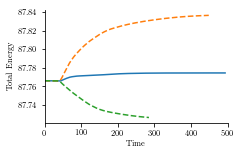

In [83]:
rke_folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/test-rke/v1e-4r5e-4.5-test-rke-switching/Data/"
no_rke_energy = Energy(rke_folder + "en.dat")

fig, axis = plt.subplots()
fig.subplots_adjust(left=.185, bottom=.19, right=.97, top=.97)

fix_ohmic_heating_restart(isotropic_energy.data[:,5])
fix_ohmic_heating_restart(switching_energy.data[:,5])

# iso_energy_sum = np.sum(isotropic_energy.data[:,[1,2,3]], axis=1)
# swi_energy_sum = np.sum(switching_energy.data[:,[1,2,3]], axis=1)

iso_energy_sum = sum_energy_data(isotropic_energy.data)
swi_energy_sum = sum_energy_data(switching_energy.data)
no_rke_energy_sum = sum_energy_data(no_rke_energy.data)

axis.plot(isotropic_energy.data[:,0], iso_energy_sum, '-')
axis.plot(switching_energy.data[:,0], swi_energy_sum, '--')
axis.plot(no_rke_energy.data[:,0], no_rke_energy_sum, '--')

plt.xlim(0, 500)
# plt.ylim(0, 0.06)

plt.xlabel(r'Time')
plt.ylabel(r'Total Energy')
remove_spines(axis)

# plt.savefig('internal_energy_over_time.pdf', pad_inches=0.0)

plt.show()

# s parameter study

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 415
num_sz: 8
n_vars: 12
id_length: 32
LOADING DATA
data size: 440268
n_timesteps: 36689
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 415
num_sz: 8
n_vars: 12
id_length: 32
LOADING DATA
data size: 748260
n_timesteps: 62355
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 457688
n_timesteps: 50854
offset: 2
spare numbers: [ 304.291951     86.07412375]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 415
num_sz: 8
n_vars: 12
id_length: 32
LOADING DATA
data size: 447436
n_timesteps: 37286
offset: 4
spare numbers: [  2.72218252e+02   8.60894777e+01   5.03377366e-02   1.63437641e+00]


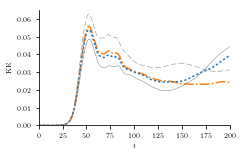

In [51]:
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/s-parameter-study"
s_values = ["1.0", "0.6", "0.5", "0"]
filenames = [folder + "/v1e-4r5e-4.5-fixed-switching-" + s + "-switching/Data/en.dat" for s in s_values]
energies = [Energy(filename) for filename in filenames]

latexify(columns=2)
fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.19, right=.97, top=.99)

axis.set_xlim(0, 200)
axis.set_ylim(0, 0.065)

idx = 2

axis.plot(energies[0].data[:,0], energies[0].data[:,idx], '--', color='0.5', linewidth=0.5)
axis.plot(energies[1].data[:,0], energies[1].data[:,idx], '-.', color='tab:orange')
axis.plot(energies[2].data[:,0], energies[2].data[:,idx], ':', color='tab:blue')
axis.plot(energies[3].data[:,0], energies[3].data[:,idx], '-', color='0.5', linewidth=0.5)

plt.ylabel("KE")
plt.xlabel(r"$t$")

remove_spines(axis)
plt.savefig("kinetic-energy-changing-s.pdf", pad_inches=0.0)
plt.show()

# Parameter study plots (maximum kinetic energy over viscosity)

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 828180
n_timesteps: 92020
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 841077
n_timesteps: 93453
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 861154
n_timesteps: 95683
offset: 7
spare numbers: [  5.98384833e+02   8.59807225e+01   1.28108526e-03   1.78596599e+00
   3.20337533e-01   1.41243362e-01   1.28025444e-03]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 900350
n_timesteps: 100038
offset: 8
spare numbers: [  5.78133087e+02   8.59750983e+01   2.65307970e-03   1.79248270e+00
   3.32864936e-01   1.21737890e-01   2.65187110e-03   1.20859381e-06]
LOADING HEADER
versi

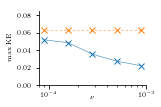

In [185]:
exponents = ["3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/viscosity-parameter-study-long"
iso_filenames = [folder + "/v5e-" + exponent + "r5e-4.5-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v5e-" + exponent + "r5e-4.5-switching/Data/en.dat" for exponent in exponents]

latexify(columns=3)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.22, bottom=.18, right=.94, top=.99)

exponents = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

iso_ohmic_diff = []

axis.semilogx(exponents, get_maxes(iso_filenames, 2, max_time=400), "-", marker='x', color="tab:blue", linewidth=0.5, label="Isotropic Total")
# axis.semilogx(exponents, get_maxes(iso_filenames, 6), "r-", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Isotropic Parallel")
# axis.semilogx(exponents, get_maxes(iso_filenames, 7), "b-", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Isotropic Perp")

axis.semilogx(exponents, get_maxes(swi_filenames, 2, max_time=400), ":", marker='x', color="tab:orange", linewidth=0.5, label="Switching Total")
# axis.semilogx(exponents, get_maxes(swi_filenames, 6), "r:", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Switching Parallel")
# axis.semilogx(exponents, get_maxes(swi_filenames, 7), "b:", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Switching Perp")

axis.set_ylim(0, 0.085)

## Plot mean parallel electric field too
# axis2 = axis.twinx()
# axis2.semilogx(exponents, get_maxes(swi_filenames, 2), "x--", color="0.5", label="Switching Total")
# axis2.semilogx(exponents, get_maxes(swi_filenames, 6), "xr--", label="Switching Parallel")
# axis2.semilogx(exponents, get_maxes(swi_filenames, 7), "xb--", label="Switching Perp")

remove_spines(axis)

axis.set_xlabel(r"$\nu$", labelpad=-5)
axis.set_ylabel("max KE")

plt.savefig("max_kinetic_changing_visc.pdf", pad_inches=0.0)
plt.show()

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 114616
n_timesteps: 14327
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 110352
n_timesteps: 13794
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 118656
n_timesteps: 14832
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 111528
n_timesteps: 13941
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 104288
n_timesteps: 13036
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 1010

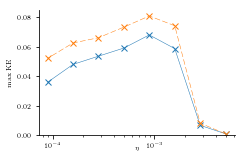

In [204]:
## Over resistivity

exponents = ["3", "3.25", "3.5", "3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/slowly-changing-resist"
iso_filenames = [folder + "/v1e-4r5e-" + exponent + "-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v1e-4r5e-" + exponent + "-switching/Data/en.dat" for exponent in exponents]

latexify(columns=2)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.12, right=.99, top=.99)

exponents = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

axis.semilogx(exponents, get_maxes(iso_filenames, 2, max_time=125), "-", marker='x', color="tab:blue", linewidth=0.5, label="Isotropic Total")
# axis.semilogx(exponents, get_maxes(iso_filenames, 6, max_time=125), "-", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Isotropic Parallel")
# axis.semilogx(exponents, get_maxes(iso_filenames, 7, max_time=125), "-", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Isotropic Perp")

axis.semilogx(exponents, get_maxes(swi_filenames, 2, max_time=125), "--", marker='x', color="tab:orange", linewidth=0.5, label="Switching Total")
# axis.semilogx(exponents, get_maxes(swi_filenames, 6, max_time=125), "--", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Switching Parallel")
# axis.semilogx(exponents, get_maxes(swi_filenames, 7, max_time=125), "--", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Switching Perp")

remove_spines(axis)

axis.set_ylim(0, 0.085)

axis.set_xlabel(r"$\eta$", labelpad=-5)
axis.set_ylabel("max KE")

plt.savefig("max_kinetic_changing_resist.pdf", pad_inches=0.0)

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 219360
n_timesteps: 27420
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 624840
n_timesteps: 78105
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 643120
n_timesteps: 80390
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 638040
n_timesteps: 79755
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 648632
n_timesteps: 81079
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 2481

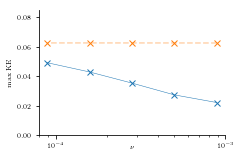

In [355]:
## Over viscosity

exponents = ["3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/slowly-changing-visc"
iso_filenames = [folder + "/v5e-" + exponent + "r5e-4.5-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v5e-" + exponent + "r5e-4.5-switching/Data/en.dat" for exponent in exponents]

latexify(columns=2)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.12, right=.95, top=.99)

exponents = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

axis.semilogx(exponents, get_maxes(iso_filenames, 2, max_time=125), "-", marker='x', color="tab:blue", linewidth=0.5, label="Isotropic Total")
# axis.semilogx(exponents, get_maxes(iso_filenames, 6, max_time=125), "-", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Isotropic Parallel")
# axis.semilogx(exponents, get_maxes(iso_filenames, 7, max_time=125), "-", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Isotropic Perp")

axis.semilogx(exponents, get_maxes(swi_filenames, 2, max_time=125), "--", marker='x', color="tab:orange", linewidth=0.5, label="Switching Total")
# axis.semilogx(exponents, get_maxes(swi_filenames, 6, max_time=125), "--", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Switching Parallel")
# axis.semilogx(exponents, get_maxes(swi_filenames, 7, max_time=125), "--", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Switching Perp")

remove_spines(axis)

axis.set_ylim(0, 0.085)

axis.set_xlabel(r"$\nu$", labelpad=-5)
axis.set_ylabel("max KE")

plt.savefig("max_early_time_kinetic_changing_visc.pdf", pad_inches=0.0)

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 470315
n_timesteps: 52257
offset: 2
spare numbers: [ 304.97987036   85.89638767]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 637410
n_timesteps: 70823
offset: 3
spare numbers: [  4.19315251e+02   8.59023309e+01   2.72198103e-04]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 486527
n_timesteps: 54058
offset: 5
spare numbers: [  3.36027660e+02   8.59527669e+01   2.45008048e-03   1.81107655e+00
   1.33458534e-01]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 651559
n_timesteps: 72395
offset: 4
spare numbers: [  4.60698866e+02   8.59731030e+01   1.57681898e-03   1.79267518e+00]
LOADING HEA

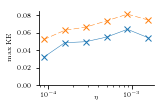

In [338]:
## total Over resistivity

exponents = ["3.5", "3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/resistivity-parameter-study-long"
iso_filenames = [folder + "/v5e-4.5r5e-" + exponent + "-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v5e-4.5r5e-" + exponent + "-switching/Data/en.dat" for exponent in exponents]

latexify(columns=3)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.22, bottom=.16, right=.99, top=.97)

exponents = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

axis.semilogx(exponents, get_maxes(iso_filenames, 2, max_time=400), "-", marker='x', color="tab:blue", linewidth=0.5, label="Isotropic Total")
# axis.semilogx(exponents, get_maxes(iso_filenames, 6, max_time=125), "-", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Isotropic Parallel")
# axis.semilogx(exponents, get_maxes(iso_filenames, 7, max_time=125), "-", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Isotropic Perp")

axis.semilogx(exponents, get_maxes(swi_filenames, 2, max_time=400), "--", marker='x', color="tab:orange", linewidth=0.5, label="Switching Total")
# axis.semilogx(exponents, get_maxes(swi_filenames, 6, max_time=125), "--", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Switching Parallel")
# axis.semilogx(exponents, get_maxes(swi_filenames, 7, max_time=125), "--", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Switching Perp")

remove_spines(axis)

axis.set_ylim(0, 0.085)

axis.set_xlabel(r"$\eta$", labelpad=-5)
axis.set_ylabel("max KE")

plt.savefig("max_total_kinetic_changing_resist.pdf", pad_inches=0.0)

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 470315
n_timesteps: 52257
offset: 2
spare numbers: [ 304.97987036   85.89638767]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 637410
n_timesteps: 70823
offset: 3
spare numbers: [  4.19315251e+02   8.59023309e+01   2.72198103e-04]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 486527
n_timesteps: 54058
offset: 5
spare numbers: [  3.36027660e+02   8.59527669e+01   2.45008048e-03   1.81107655e+00
   1.33458534e-01]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 651559
n_timesteps: 72395
offset: 4
spare numbers: [  4.60698866e+02   8.59731030e+01   1.57681898e-03   1.79267518e+00]
LOADING HEA

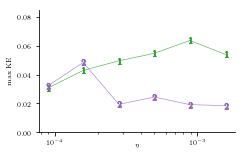

In [368]:
## total over resistivity (separate instabilities)

exponents = ["3.5", "3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/resistivity-parameter-study-long"
iso_filenames = [folder + "/v5e-4.5r5e-" + exponent + "-isotropic/Data/en.dat" for exponent in exponents]

latexify(columns=2)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.12, right=.99, top=.97)

exponents = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

energies = [Energy(f) for f in iso_filenames]
split_times = [100,100,140,140,140,140]
maxes1 = [get_max(energies[i].data, 2, max_time=split_times[i]) for i in range(len(exponents))]
maxes2 = [get_max(energies[i].data, 2, min_time=split_times[i]) for i in range(len(exponents))]

axis.semilogx(exponents, maxes1, "-", marker='$1$', color="tab:green", linewidth=0.5, label="Isotropic Total")
axis.semilogx(exponents, maxes2, "-", marker='$2$', color="tab:purple", linewidth=0.5, label="Isotropic Total")
# axis.semilogx(exponents, get_maxes(iso_filenames, 6, max_time=125), "-", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Isotropic Parallel")
# axis.semilogx(exponents, get_maxes(iso_filenames, 7, max_time=125), "-", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Isotropic Perp")

# axis.semilogx(exponents, get_maxes(swi_filenames, 2, max_time=125), "--", marker='x', color="tab:green", linewidth=0.5, label="Switching Total")
# axis.semilogx(exponents, get_maxes(swi_filenames, 2, min_time=125), "--", marker='x', color="tab:purple", linewidth=0.5, label="Switching Total")
# axis.semilogx(exponents, get_maxes(swi_filenames, 6, max_time=125), "--", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Switching Parallel")
# axis.semilogx(exponents, get_maxes(swi_filenames, 7, max_time=125), "--", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Switching Perp")

remove_spines(axis)

axis.set_ylim(0, 0.085)

axis.set_xlabel(r"$\eta$", labelpad=-5)
axis.set_ylabel("max KE")

plt.savefig("max_ke_split_inst_changing_resistivity.pdf", pad_inches=0.0)

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 828180
n_timesteps: 92020
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 841077
n_timesteps: 93453
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 861154
n_timesteps: 95683
offset: 7
spare numbers: [  5.98384833e+02   8.59807225e+01   1.28108526e-03   1.78596599e+00
   3.20337533e-01   1.41243362e-01   1.28025444e-03]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 900350
n_timesteps: 100038
offset: 8
spare numbers: [  5.78133087e+02   8.59750983e+01   2.65307970e-03   1.79248270e+00
   3.32864936e-01   1.21737890e-01   2.65187110e-03   1.20859381e-06]
LOADING HEADER
versi

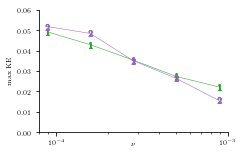

In [369]:
## total over viscosity (separate instabilities)

exponents = ["3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/viscosity-parameter-study-long"
iso_filenames = [folder + "/v5e-" + exponent + "r5e-4.5-isotropic/Data/en.dat" for exponent in exponents]

latexify(columns=2)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.12, right=.96, top=.97)

exponents = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

energies = [Energy(f) for f in iso_filenames]
split_times = [130]*5
maxes1 = [get_max(energies[i].data, 2, max_time=split_times[i]) for i in range(len(exponents))]
maxes2 = [get_max(energies[i].data, 2, min_time=split_times[i]) for i in range(len(exponents))]

axis.semilogx(exponents, maxes1, "-", marker='$1$', color="tab:green", linewidth=0.5, label="Isotropic Total")
axis.semilogx(exponents, maxes2, "-", marker='$2$', color="tab:purple", linewidth=0.5, label="Isotropic Total")
# axis.semilogx(exponents, get_maxes(iso_filenames, 6, max_time=125), "-", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Isotropic Parallel")
# axis.semilogx(exponents, get_maxes(iso_filenames, 7, max_time=125), "-", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Isotropic Perp")

# axis.semilogx(exponents, get_maxes(swi_filenames, 2, max_time=125), "--", marker='x', color="tab:green", linewidth=0.5, label="Switching Total")
# axis.semilogx(exponents, get_maxes(swi_filenames, 2, min_time=125), "--", marker='x', color="tab:purple", linewidth=0.5, label="Switching Total")
# axis.semilogx(exponents, get_maxes(swi_filenames, 6, max_time=125), "--", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Switching Parallel")
# axis.semilogx(exponents, get_maxes(swi_filenames, 7, max_time=125), "--", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Switching Perp")

remove_spines(axis)

axis.set_ylim(0, 0.06)

axis.set_xlabel(r"$\nu$", labelpad=-5)
axis.set_ylabel("max KE")

plt.savefig("max_ke_split_inst_changing_viscosity.pdf", pad_inches=0.0)

# Integrated kinetic energy

In [261]:
def integrate(filenames, index, max_time=-1):
    energies = [Energy(f) for f in filenames]
    return [integrate_data(en.data, index, max_time) for en in energies]

def integrate_data(data, index, max_time=-1):
    if max_time > 0:
        # calc what the index corresponding to max_time is
        max_index = find_nearest(data[:,0], max_time)
    else:
        # max_index is one past the end
        max_index = len(data[:,0]) + 1
        
    time_domain = data[:max_index, 0]
    integrand = data[:max_index, index]
    
    dt = time_domain[1:] - time_domain[:-1]
    
    integration = np.sum(0.5*(integrand[1:] + integrand[:-1]) * dt)
    
    return integration

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 470315
n_timesteps: 52257
offset: 2
spare numbers: [ 304.97987036   85.89638767]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 637410
n_timesteps: 70823
offset: 3
spare numbers: [  4.19315251e+02   8.59023309e+01   2.72198103e-04]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 486527
n_timesteps: 54058
offset: 5
spare numbers: [  3.36027660e+02   8.59527669e+01   2.45008048e-03   1.81107655e+00
   1.33458534e-01]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 651559
n_timesteps: 72395
offset: 4
spare numbers: [  4.60698866e+02   8.59731030e+01   1.57681898e-03   1.79267518e+00]
LOADING HEA

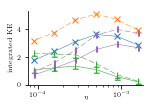

In [269]:
## total Over resistivity

exponents = ["3.5", "3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/resistivity-parameter-study-long"
iso_filenames = [folder + "/v5e-4.5r5e-" + exponent + "-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v5e-4.5r5e-" + exponent + "-switching/Data/en.dat" for exponent in exponents]

latexify(columns=3)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.22, bottom=.16, right=.99, top=.97)

exponents = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

max_time = 125

axis.semilogx(exponents, integrate(iso_filenames, 2, max_time=max_time), "-", marker='x', color="tab:blue", linewidth=0.5, label="Isotropic Total")
axis.semilogx(exponents, integrate(iso_filenames, 6, max_time=max_time), "-", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Isotropic Parallel")
axis.semilogx(exponents, integrate(iso_filenames, 7, max_time=max_time), "-", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Isotropic Perp")

axis.semilogx(exponents, integrate(swi_filenames, 2, max_time=max_time), "--", marker='x', color="tab:orange", linewidth=0.5, label="Switching Total")
axis.semilogx(exponents, integrate(swi_filenames, 6, max_time=max_time), "--", color="tab:purple", marker=r'$\parallel$', linewidth=0.5, mew=0.5, label="Switching Parallel")
axis.semilogx(exponents, integrate(swi_filenames, 7, max_time=max_time), "--", color="tab:green", marker=r'$\perp$', linewidth=0.5, mew=0.5, label="Switching Perp")

remove_spines(axis)

# axis.set_ylim(0, 0.085)

axis.set_xlabel(r"$\eta$", labelpad=-5)
axis.set_ylabel("integrated KE")

plt.savefig("integrated_total_kinetic_changing_resist.pdf", pad_inches=0.0)

# Difference in heating

In [15]:
def get_data_at_time(data, data_index, time):
    index = find_nearest(data[:,0], time)
    return data[index, data_index]

def get_min_time(filenames, data_index, time):
    energies = [Energy(f) for f in filenames]
    values = [e.data[-1,0] for e in energies]
    return min(values)

def get_at_time(filenames, data_index, time):
    energies = [Energy(f) for f in filenames]
    for e in energies:
        fix_ohmic_heating_restart(e.data[:,5])
    values = [get_data_at_time(e.data, data_index, time) for e in energies]
    return values

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 828180
n_timesteps: 92020
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 841077
n_timesteps: 93453
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 861154
n_timesteps: 95683
offset: 7
spare numbers: [  5.98384833e+02   8.59807225e+01   1.28108526e-03   1.78596599e+00
   3.20337533e-01   1.41243362e-01   1.28025444e-03]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 900350
n_timesteps: 100038
offset: 8
spare numbers: [  5.78133087e+02   8.59750983e+01   2.65307970e-03   1.79248270e+00
   3.32864936e-01   1.21737890e-01   2.65187110e-03   1.20859381e-06]
LOADING HEADER
versi

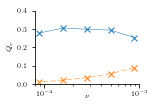

In [323]:
## visc heating varying viscosity

exponents = ["3.75","4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/viscosity-parameter-study-long"
iso_filenames = [folder + "/v5e-" + exponent + "r5e-4.5-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v5e-" + exponent + "r5e-4.5-switching/Data/en.dat" for exponent in exponents]
# swi_filenames = [folder + "/v5e-" + "4.5" + "r5e-4.5-switching/Data/en.dat" for exponent in exponents]

latexify(columns=3)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.24, bottom=.15, right=.94, top=.95)

x = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

iso_400 = np.array(get_at_time(iso_filenames, 4, 400))
swi_400 = np.array(get_at_time(swi_filenames, 4, 400))
iso_100 = np.array(get_at_time(iso_filenames, 4, 100))
swi_100 = np.array(get_at_time(swi_filenames, 4, 100))

# axis.loglog(exponents, iso_100, "-", marker=r'.', color="tab:blue", linewidth=0.5, label="Isotropic Total")
# axis.loglog(exponents, swi_100, "--", marker=r'.', color="tab:orange", linewidth=0.5, label="Isotropic Total")
axis.semilogx(x, iso_400, "-", marker=r'x', color="tab:blue", linewidth=0.5, label="Isotropic Total")
axis.semilogx(x, 1e1*swi_400, "--", marker=r'x', color="tab:orange", linewidth=0.5, label="Isotropic Total")

best_fit_exponents = [-float(exponent)+0.699 for exponent in exponents]

# swi_visc_best_fit_coeffs = np.polynomial.polynomial.Polynomial.fit(best_fit_exponents, np.log10(swi_visc_at_time), 1).coef
# swi_visc_best_fit = polyval(best_fit_exponents, swi_visc_best_fit_coeffs)

# axis.loglog(exponents, np.power(10, swi_visc_best_fit), "--", marker=r'x', color="tab:blue", linewidth=0.5, label="Isotropic Total")

# print(swi_visc_best_fit_coeffs)

x_best_fit = np.array(x).astype(float)
print(x_best_fit)
y_best_fit = x_best_fit - 1e-4 + 0.02
# axis.semilogx(x, y_best_fit, "--", color="tab:grey", linewidth=0.5, label="Isotropic Total")

axis.set_ylim(0, 0.4)

remove_spines(axis)

axis.set_xlabel(r"$\nu$", labelpad=-5)
axis.set_ylabel(r"$Q_{\nu}$")

plt.savefig("visc_heating_varying_viscosity.pdf", pad_inches=0.0)
plt.show()

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 828180
n_timesteps: 92020
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 841077
n_timesteps: 93453
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 861154
n_timesteps: 95683
offset: 7
spare numbers: [  5.98384833e+02   8.59807225e+01   1.28108526e-03   1.78596599e+00
   3.20337533e-01   1.41243362e-01   1.28025444e-03]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 900350
n_timesteps: 100038
offset: 8
spare numbers: [  5.78133087e+02   8.59750983e+01   2.65307970e-03   1.79248270e+00
   3.32864936e-01   1.21737890e-01   2.65187110e-03   1.20859381e-06]
LOADING HEADER
versi

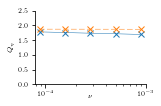

In [321]:
## ohmic heating varying viscosity

exponents = ["3.75","4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/viscosity-parameter-study-long"
iso_filenames = [folder + "/v5e-" + exponent + "r5e-4.5-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v5e-" + exponent + "r5e-4.5-switching/Data/en.dat" for exponent in exponents]
# swi_filenames = [folder + "/v5e-" + "4.5" + "r5e-4.5-switching/Data/en.dat" for exponent in exponents]

latexify(columns=3)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.20, bottom=.15, right=.94, top=.95)

exponents = [np.power(10, -float(exponent) + 0.699) for exponent in exponents]

iso_400 = np.array(get_at_time(iso_filenames, 5, 400))
swi_400 = np.array(get_at_time(swi_filenames, 5, 400))

iso_100 = np.array(get_at_time(iso_filenames, 5, 100))
swi_100 = np.array(get_at_time(swi_filenames, 5, 100))

# axis.loglog(exponents, iso_400, "-", marker=r'x', color="tab:blue", linewidth=0.5)
# axis.loglog(exponents, swi_400, "--", marker=r'x', color="tab:orange", linewidth=0.5)
axis.semilogx(exponents, iso_400, "-", marker=r'x', color="tab:blue", linewidth=0.5, label="Isotropic Total")
axis.semilogx(exponents, swi_400, "--", marker=r'x', color="tab:orange", linewidth=0.5, label="Isotropic Total")

best_fit_exponents = [-float(exponent)+0.699 for exponent in exponents]

# swi_visc_best_fit_coeffs = np.polynomial.polynomial.Polynomial.fit(best_fit_exponents, np.log10(swi_visc_at_time), 1).coef
# swi_visc_best_fit = polyval(best_fit_exponents, swi_visc_best_fit_coeffs)

# axis.loglog(exponents, np.power(10, swi_visc_best_fit), "--", marker=r'x', color="tab:blue", linewidth=0.5, label="Isotropic Total")

# print(swi_visc_best_fit_coeffs)

axis.set_ylim(0, 2.5)
# axis.set_yticks(np.linspace(1, 1.9, 5))

remove_spines(axis)

axis.set_xlabel(r"$\nu$", labelpad=-5)
axis.set_ylabel(r"$Q_{\eta}$")

plt.savefig("ohmic_heating_varying_viscosity.pdf", pad_inches=0.0)
plt.show()

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 470315
n_timesteps: 52257
offset: 2
spare numbers: [ 304.97987036   85.89638767]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 637410
n_timesteps: 70823
offset: 3
spare numbers: [  4.19315251e+02   8.59023309e+01   2.72198103e-04]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 486527
n_timesteps: 54058
offset: 5
spare numbers: [  3.36027660e+02   8.59527669e+01   2.45008048e-03   1.81107655e+00
   1.33458534e-01]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 651559
n_timesteps: 72395
offset: 4
spare numbers: [  4.60698866e+02   8.59731030e+01   1.57681898e-03   1.79267518e+00]
LOADING HEA

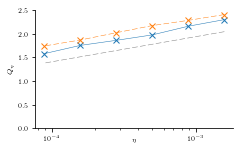

In [373]:
## ohmic heating varying resistivity

exponents = ["3.5","3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/resistivity-parameter-study-long"
iso_filenames = [folder + "/v5e-4.5r5e-" + exponent + "-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v5e-4.5r5e-" + exponent + "-switching/Data/en.dat" for exponent in exponents]

latexify(columns=2)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.14, bottom=.13, right=.99, top=.95)

x = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

iso_400 = np.array(get_at_time(iso_filenames, 5, 400))
swi_400 = np.array(get_at_time(swi_filenames, 5, 400))

iso_100 = np.array(get_at_time(iso_filenames, 5, 100))
swi_100 = np.array(get_at_time(swi_filenames, 5, 100))

# axis.loglog(exponents, iso_400, "-", marker=r'x', color="tab:blue", linewidth=0.5, label="Isotropic Total")
# axis.loglog(exponents, swi_400, "--", marker=r'x', color="tab:orange", linewidth=0.5, label="Isotropic Total")
axis.semilogx(x, iso_400, "-", marker=r'x', color="tab:blue", linewidth=0.5, label="Isotropic Total")
axis.semilogx(x, swi_400, "--", marker=r'x', color="tab:orange", linewidth=0.5, label="Isotropic Total")

# best_fit_exponents = [-float(exponent)+0.699 for exponent in exponents]

# swi_visc_best_fit_coeffs = np.polynomial.polynomial.Polynomial.fit(best_fit_exponents, np.log10(swi_visc_at_time), 1).coef
# swi_visc_best_fit = polyval(best_fit_exponents, swi_visc_best_fit_coeffs)

# axis.loglog(exponents, np.power(10, swi_visc_best_fit), "--", marker=r'x', color="tab:blue", linewidth=0.5, label="Isotropic Total")

# print(swi_visc_best_fit_coeffs)

gradient = -(swi_400[-1] - swi_400[0])/(float(exponents[-1]) - float(exponents[0]))
exps = np.array([float(exp) for exp in exponents[::-1]])
c = - gradient*float(exponents[0]) + iso_400[-1]

line_best_fit = gradient*exps + c - 0.2
# print(gradient)
axis.semilogx(x, line_best_fit, "--", color="tab:grey", linewidth=0.5, label="Isotropic Total")

print("Q=", gradient, "log_10 \eta", - gradient*float(exponents[0]) + iso_400[-1])

c = gradient*float(exponents[0]) + iso_400[-1]
print("Q=", gradient*-6 + c)

# print(iso_400[-1], exponents[-1])
axis.set_ylim(0, 2.5)

remove_spines(axis)

axis.set_xlabel(r"$\eta$", labelpad=-5)
axis.set_ylabel(r"$Q_{\eta}$")

plt.savefig("ohmic_heating_varying_resistivity.pdf", pad_inches=0.0)
plt.show()

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 470315
n_timesteps: 52257
offset: 2
spare numbers: [ 304.97987036   85.89638767]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 637410
n_timesteps: 70823
offset: 3
spare numbers: [  4.19315251e+02   8.59023309e+01   2.72198103e-04]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 486527
n_timesteps: 54058
offset: 5
spare numbers: [  3.36027660e+02   8.59527669e+01   2.45008048e-03   1.81107655e+00
   1.33458534e-01]
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 319
num_sz: 8
n_vars: 9
id_length: 32
LOADING DATA
data size: 651559
n_timesteps: 72395
offset: 4
spare numbers: [  4.60698866e+02   8.59731030e+01   1.57681898e-03   1.79267518e+00]
LOADING HEA

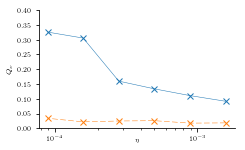

In [375]:
## visc heating varying resistivity

exponents = ["3.5","3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/resistivity-parameter-study-long"
iso_filenames = [folder + "/v5e-4.5r5e-" + exponent + "-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v5e-4.5r5e-" + exponent + "-switching/Data/en.dat" for exponent in exponents]

latexify(columns=2)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.13, right=.99, top=.95)

exponents = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

iso_400 = np.array(get_at_time(iso_filenames, 4, 400))
swi_400 = np.array(get_at_time(swi_filenames, 4, 400))

iso_100 = np.array(get_at_time(iso_filenames, 4, 100))
swi_100 = np.array(get_at_time(swi_filenames, 4, 100))

# axis.loglog(exponents, iso_100, "-", marker=r'.', color="tab:blue", linewidth=0.5, label="Isotropic Total")
# axis.loglog(exponents, swi_100, "--", marker=r'.', color="tab:orange", linewidth=0.5, label="Isotropic Total")
axis.semilogx(exponents, iso_400, "-", marker=r'x', color="tab:blue", linewidth=0.5, label="Isotropic Total")
axis.semilogx(exponents, 1e1*swi_400, "--", marker=r'x', color="tab:orange", linewidth=0.5, label="Isotropic Total")

# best_fit_exponents = [-float(exponent)+0.699 for exponent in exponents]

# swi_visc_best_fit_coeffs = np.polynomial.polynomial.Polynomial.fit(best_fit_exponents, np.log10(swi_visc_at_time), 1).coef
# swi_visc_best_fit = polyval(best_fit_exponents, swi_visc_best_fit_coeffs)

# axis.loglog(exponents, np.power(10, swi_visc_best_fit), "--", marker=r'x', color="tab:blue", linewidth=0.5, label="Isotropic Total")

# print(swi_visc_best_fit_coeffs)

axis.set_ylim(0, 0.4)

remove_spines(axis)

axis.set_xlabel(r"$\eta$", labelpad=-5)
axis.set_ylabel(r"$Q_{\nu}$")

plt.savefig("visc_heating_varying_resistivity.pdf", pad_inches=0.0)
plt.show()

# Plotting s function

/maths/scratch/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/maths/scratch/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp
/maths/scratch/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in multiply
/maths/scratch/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/maths/scratch/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in subtract


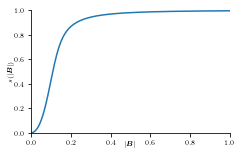

In [81]:
# Concentration param
aMax = 30

B = np.linspace(0, 2, num=1000)

a = 150 * B*B

# Calculate kappa parameter
kappa_erfi = 1/2.0*(1 + 1/(4*a)) - np.exp(2*a)/(2*np.sqrt(2*np.pi*a)*special.erfi(np.sqrt(2*a)))
kappa_erfi[0] = 1.0/3
kappa_erfi[a>150*1.52*1.52] = 0.000722355018311

s_erfi = 1.0-3.0*kappa_erfi
latexify(columns=2)

fig, axis = plt.subplots()
fig.subplots_adjust(left=.12, bottom=.13, right=.97, top=.98)

axis.plot(B, s_erfi)
plt.xlabel(r"$|\boldsymbol{B}|$", labelpad=-5)
plt.ylabel(r"$s(|\boldsymbol{B}|)$", labelpad=0)
plt.ylim(0, 1)
remove_spines(axis)
plt.xlim(0, 1)
# plt.xticks(np.linspace(0, 1000, num=4), [0, 10, 20, 30])
# plt.title("Switch function")
plt.savefig("s_function.pdf",  pad_inches=0.0)
plt.show()

# Calculating growth rate over $\eta$

In [32]:
def calc_gradient(energy, x_index, y_index, start_end):
    return (np.log10(get_data_at_time(energy.data, y_index, start_end[1])) - np.log10(get_data_at_time(energy.data, y_index, start_end[0])))\
/(get_data_at_time(energy.data, x_index, start_end[1]) - get_data_at_time(energy.data, x_index, start_end[0]))

def create_log_line(gradient, point, x):
    return np.power(10, gradient*(x-point[0]))*point[1]

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 114616
n_timesteps: 14327
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 110352
n_timesteps: 13794
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 118656
n_timesteps: 14832
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 111528
n_timesteps: 13941
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 104288
n_timesteps: 13036
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 1010

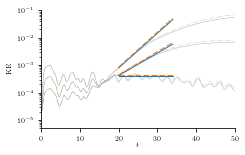

In [197]:
## ohmic heating varying resistivity

exponents = ["3", "3.25", "3.5", "3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/slowly-changing-resist"
iso_filenames = [folder + "/v1e-4r5e-" + exponent + "-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v1e-4r5e-" + exponent + "-switching/Data/en.dat" for exponent in exponents]

iso_energies = [Energy(filename) for filename in iso_filenames]
swi_energies = [Energy(filename) for filename in swi_filenames]

latexify(columns=2)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.15, right=.98, top=.97)

x = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

n_exp = len(exponents)

for i in range(3):
    axis.semilogy(iso_energies[i].data[:,0], iso_energies[i].data[:,2], "-",color="tab:blue", linewidth=0.25, label="Isotropic Total")
    axis.semilogy(swi_energies[i].data[:,0], swi_energies[i].data[:,2], "--", color="tab:orange", linewidth=0.25, label="Isotropic Total")

start_ends = [
    (19,22),
    (20,22),
    (21,22),
    (24,25),
    (24,25),
    (27,28),
    (27,28),
    (32,33)
]

iso_gradients = [calc_gradient(iso_energies[i], 0, 2, start_ends[i]) for i in range(n_exp)]
swi_gradients = [calc_gradient(swi_energies[i], 0, 2, start_ends[i]) for i in range(n_exp)]

iso_gradients[0] = swi_gradients[0] = 0

t = np.linspace(20, 34, 10)

iso_lines = [create_log_line(iso_gradients[i], 
                             (start_ends[i][0], get_data_at_time(iso_energies[i].data, 2, start_ends[i][0])),
                             t) for i in range(n_exp)]

swi_lines = [create_log_line(swi_gradients[i], 
                             (start_ends[i][0], get_data_at_time(swi_energies[i].data, 2, start_ends[i][0])),
                             t) for i in range(n_exp)]

for i in range(3):
    plt.semilogy(t, iso_lines[i], "-",color="tab:blue", linewidth=1.0,)
    plt.semilogy(t, swi_lines[i], "--",color="tab:orange", linewidth=1.0,)

print(iso_gradients)
print(swi_gradients)
# exps = np.array([float(exp) for exp in exponents[::-1]])
# line_best_fit = -gradient*exps - 0.5
# print(gradient)
# axis.semilogx(x, line_best_fit, "--", color="tab:grey", linewidth=0.5, label="Isotropic Total")

axis.set_xlim(0, 50)
axis.set_ylim(5e-6, 1e-1)

remove_spines(axis)

axis.set_xlabel(r"$t$", labelpad=0)
axis.set_ylabel(r"KE")

plt.savefig("log_KE_over_time_resistivity.pdf", pad_inches=0.0)
plt.show()

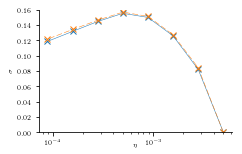

In [199]:
latexify(columns=2)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.12, right=.98, top=.97)

x = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

axis.semilogx(x, iso_gradients, "-", marker=r'x', color="tab:blue", linewidth=0.5)
axis.semilogx(x, swi_gradients, "--", marker=r'x', color="tab:orange", linewidth=0.5)

eta = np.linspace(float(x[0]), float(x[-1]))

y = np.power(eta, 1.0/3.0) + 0.08

# plt.semilogx(eta,y)

remove_spines(axis)

axis.set_ylim(0.0, 0.16)

axis.set_xlabel(r"$\eta$", labelpad=-5)
axis.set_ylabel(r"$\sigma$")

plt.savefig("growth_rate_varying_resistivity.pdf", pad_inches=0.0)
plt.show()

# Calculating growth rate over $\nu$

LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 219360
n_timesteps: 27420
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 624840
n_timesteps: 78105
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 643120
n_timesteps: 80390
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 638040
n_timesteps: 79755
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 648632
n_timesteps: 81079
offset: 0
LOADING HEADER
version: 1
revision: 0
endianness: 16911887
header_length: 287
num_sz: 8
n_vars: 8
id_length: 32
LOADING DATA
data size: 2481

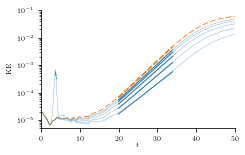

In [351]:
## ohmic heating varying visc

exponents = ["3.75", "4", "4.25", "4.5", "4.75"]
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/slowly-changing-visc"
iso_filenames = [folder + "/v5e-"+exponent+"r5e-4.5-isotropic/Data/en.dat" for exponent in exponents]
swi_filenames = [folder + "/v5e-"+exponent+"r5e-4.5-switching/Data/en.dat" for exponent in exponents]

iso_energies = [Energy(filename) for filename in iso_filenames]
swi_energies = [Energy(filename) for filename in swi_filenames]

latexify(columns=2)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.15, right=.98, top=.97)

x = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

n_exp = len(exponents)

for i in range(n_exp):
    axis.semilogy(iso_energies[i].data[:,0], iso_energies[i].data[:,2], "-",color="tab:blue", linewidth=0.25, label="Isotropic Total")
    axis.semilogy(swi_energies[i].data[:,0], swi_energies[i].data[:,2], "--", color="tab:orange", linewidth=0.25, label="Isotropic Total")

start_ends = [
    (28,29),
    (28,29),
    (28,29),
    (28,29),
    (28,29),
]

iso_gradients = [calc_gradient(iso_energies[i], 0, 2, start_ends[i]) for i in range(n_exp)]
swi_gradients = [calc_gradient(swi_energies[i], 0, 2, start_ends[i]) for i in range(n_exp)]

# iso_gradients[0] = swi_gradients[0] = 0

t = np.linspace(20, 34, 10)

iso_lines = [create_log_line(iso_gradients[i], 
                             (start_ends[i][0], get_data_at_time(iso_energies[i].data, 2, start_ends[i][0])),
                             t) for i in range(n_exp)]

swi_lines = [create_log_line(swi_gradients[i], 
                             (start_ends[i][0], get_data_at_time(swi_energies[i].data, 2, start_ends[i][0])),
                             t) for i in range(n_exp)]

for i in range(n_exp):
    plt.semilogy(t, iso_lines[i], "-",color="tab:blue", linewidth=1.0,)
    plt.semilogy(t, swi_lines[i], "--",color="tab:orange", linewidth=1.0,)

print(iso_gradients)
print(swi_gradients)
# exps = np.array([float(exp) for exp in exponents[::-1]])
# line_best_fit = -gradient*exps - 0.5
# print(gradient)
# axis.semilogx(x, line_best_fit, "--", color="tab:grey", linewidth=0.5, label="Isotropic Total")

axis.set_xlim(0, 50)
axis.set_ylim(5e-6, 1e-1)

remove_spines(axis)

axis.set_xlabel(r"$t$", labelpad=0)
axis.set_ylabel(r"KE")

plt.savefig("log_KE_over_time_viscosity.pdf", pad_inches=0.0)
plt.show()

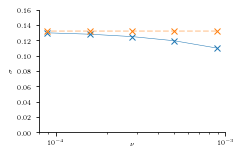

In [354]:
latexify(columns=2)

fig, axis = plt.subplots(1)
fig.subplots_adjust(left=.15, bottom=.12, right=.95, top=.97)

x = [str(np.power(10, -float(exponent) + 0.699)) for exponent in exponents]

axis.semilogx(x, iso_gradients, "-", marker=r'x', color="tab:blue", linewidth=0.5)
axis.semilogx(x, swi_gradients, "--", marker=r'x', color="tab:orange", linewidth=0.5)

eta = np.linspace(float(x[0]), float(x[-1]))

y = np.power(eta, 1.0/3.0) + 0.08

# plt.semilogx(eta,y)

remove_spines(axis)

axis.set_ylim(0.0, 0.16)

axis.set_xlabel(r"$\nu$", labelpad=-5)
axis.set_ylabel(r"$\sigma$")

plt.savefig("growth_rate_varying_viscosity.pdf", pad_inches=0.0)
plt.show()